# `fRMI on our data`: Voxelwise encoding models
fMRI shtuff leggoo !

In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pandas as pd

In [2]:
## new imports ## 
import json
from nilearn import datasets, plotting
from nilearn.masking import unmask
from nilearn.plotting import plot_stat_map
from scipy.stats import zscore
from utils_anal import load_epi_data, resample_atlas, get_network_labels

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Example data 
As an example, we'll use fMRI data collected for a single subject listening to a spoken story called "[I Knew You Were Black](https://themoth.org/stories/i-knew-you-were-black)" by Carol Daniel. These data are available as part of the publicly available [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)). Here, we'll download a single subject from the server for analysis. If you're working on the server, use `cp` on the command line to create a copy of the following file in your working directory; if you're working locally, use `scp` to download the file to your machine:

`/jukebox/PNI-classes/students/NEU502/2023-NEU502B/brainiak-aperture-data/sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz`

This dataset has been preprocessed using fMRIPrep with confound regression in AFNI. The functional data have been spatially normalized to a template in MNI space. To reduce computational demands, we compute parcel-wise ISCs using a cortical parcellation containing 400 parcels from [Schaefer and colleages (2018)](https://doi.org/10.1093/cercor/bhx179). Load in the functional data and atlas. Use the parcellation to extract the mean functional time series for each parcel.

In [3]:
# Filenames for intact notthefall data and Schaefer atlas
func_fn = ('sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz')
atlas_fn = ('Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2.5mm.nii.gz')

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

# Load in intact functional data and compute parcel means:
func_data = nib.load(func_fn).get_fdata()

func_means = [np.mean(func_data[atlas_img == parcel, :], axis=0)
              for parcel in np.unique(atlas_img)[1:]]
func_parcels = np.column_stack(func_means)

In [4]:
func_parcels.shape

(550, 400)

To orient ourselves a bit, let's try plotting the BOLD time series for an example parcel. Start with parcel `196` in left superior temporal auditory association cortex. After plotting the time series, plot the location of this parcel in the brain using `plot_stat_map`.

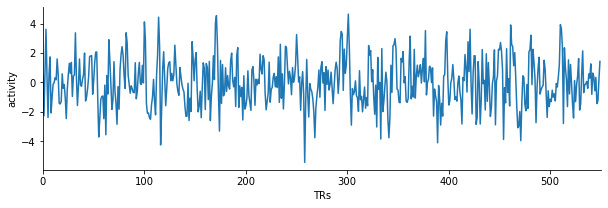

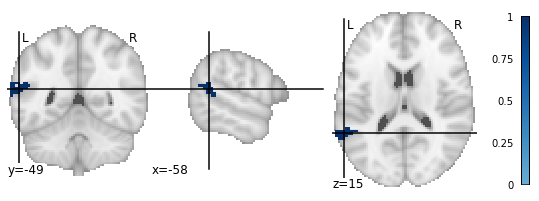

In [5]:
# Plot the time series for an example parcel:

example_parcel = 200
func_parcel = func_parcels[:, example_parcel]

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(func_parcel)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, len(func_parcel)))
sns.despine()

# Plot parcel on MNI atlas:
roi_img = np.zeros(atlas_img.shape)
roi_img[atlas_img == example_parcel] = 1
roi_nii = nib.Nifti1Image(roi_img, atlas_nii.affine, atlas_nii.header)
plot_stat_map(roi_nii, cmap='Blues');

# OUR data YAY ! 

In [6]:
# ## directories 
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'

### length of each movie 

just putting this here for future reference -- how many TRs exist for every movie

In [7]:
## TR length of each movie ## 
mov_len_dic = {
'oragami' :  82,
'shrek' : 90,
'sherlock' : 98,
'brushing' : 88,
'cake' : 99,
'office' : 102    
}

### Load in target atlas

This section reads in 400 target brain regions and averages timecoureses for region.
No changes are necessary

In [8]:
##### Variables for the atlas ### 

num_parc = 400 ## CHANGE ME
num_net= 17 ## CHANGE ME


###### ROI Loading ### 
# LOAD ATLAS #
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

# Load in network labels for each parcell, parcel UNspecific network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)
two networks: ['L VisCent', 'L VisPeri'] 
 total nets: 34


### load fMRI

Here we load in the fMRI data

In [9]:
## external data
ext_isc = np.load(f'{isc_dir}/n39_ext_isc.npz')

## Internal data
int_isc = np.load(f'{isc_dir}/n39_int_isc.npz')

In [10]:
## examine all data in the dictionary #
for key in ext_isc:
    print(key)

office
cake
brushing
sherlock
oragami
shrek


In [11]:
## grab shrek data for ALL subjects 

In [12]:
shrek_d = ext_isc['shrek']

In [13]:
## 90 TRs, 112179 voxels, 4 runs, 19 subjects ## 
shrek_d.shape

(90, 112179, 4, 19)

In [14]:
## which run to select?
targ_run = 1
## which subject to select?
targ_sub = 7
## load and print shape
shrk_1_2d = shrek_d[..., targ_run, targ_sub]
shrk_1_2d.shape

(90, 112179)

In [15]:
shrk_1_2d.shape[0]

90

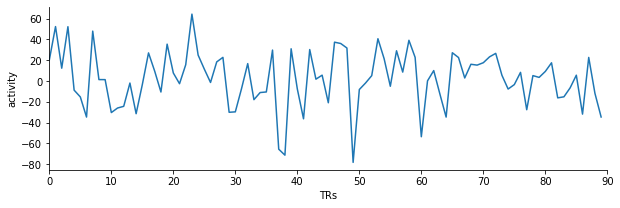

In [16]:
## plot one voxel's timeseries
one_vox = shrk_1_2d[:,23003]

# plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(one_vox)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, 90))
sns.despine()

### preprocess data -- convert back to fMRI image 

In [17]:
## brain mask  ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
## Take the 2d file and convert it to a 4 D fMRI image 
shrek_nii = unmask(shrk_1_2d, ref_nii)
shrek_nii.shape

(78, 93, 65, 90)

## Get timeseries data for each region (parcel)

In [18]:
# Load in intact functional data and compute parcel means:
func_data = shrek_nii.get_fdata()

func_means = [np.mean(func_data[atlas_img == parcel, :], axis=0)
              for parcel in np.unique(atlas_img)[1:]]
func_parcels = np.column_stack(func_means)

In [19]:
func_parcels.shape

(90, 400)

## Plot

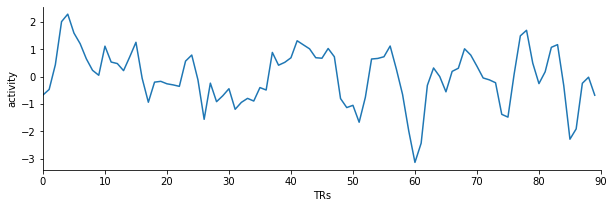

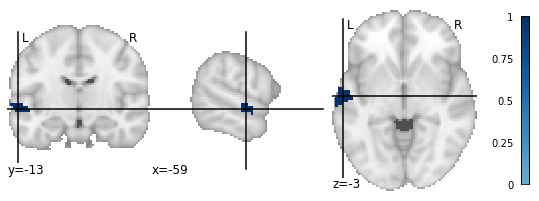

In [20]:
# Plot the time series for an example parcel:

example_parcel = 196
func_parcel = func_parcels[:, example_parcel]

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(zscore(func_parcel))
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, len(func_parcel)))
sns.despine()

# Plot parcel on MNI atlas:
roi_img = np.zeros(atlas_img.shape)
roi_img[atlas_img == example_parcel] = 1
roi_nii = nib.Nifti1Image(roi_img, atlas_nii.affine, atlas_nii.header)
plot_stat_map(roi_nii, cmap='Blues');

### save one subject

In [75]:
name = 'shrek_ext_07.npy'

In [76]:
#np.save(name, func_parcels)

# alternative code that saves all subjects using for loop


In [ ]:
name = 'shrek_fMRI_external.npy'

In [ ]:
sub_dict = {}

In [ ]:
#for loop to save target run for all subjects
for subject in range(0, 19):
    
    #select run and subject
    targ_run = 1
    targ_sub = subject
    
    #load and print shape
    shrk_1_2d = shrek_d[..., targ_run, targ_sub]
    
    #create brain mask
    ref_nii = nib.load("whole_b_bnk.nii.gz")
    
    #convert 2D file to 4D fMRI image
    shrek_nii = unmask(shrk_1_2d, ref_nii)
    
    #load in intact functional data and compute parcel means
    func_data = shrek_nii.get_fdata()

    func_means = [np.mean(func_data[atlas_img == parcel, :], axis=0)
                  for parcel in np.unique(atlas_img)[1:]]
    func_parcels = np.column_stack(func_means)

    # Save with subject-specific filename
    name = f'shrek_fMRI_external_SUBJECT_{targ_sub}_npt.npy'
    sub_dict[subject] = func_parcels
    print(f"Saved data for subject {targ_sub} to {name}")

In [ ]:
np.save("externalR1_data.npy", sub_dict)